<table>
<tr>
    <td width=20%>
        <img src="logo-uca-site.png" width="100%"/>
    </td>
    <td width=60%>
        <center>
            <h1>Projet Machine Learning</h1>
            <h2>Problematique : Alzheimer's dataset</h2>
        </center>
    </td>
    <td width=20%>
        <a href="theo.jean2@etu.uca.fr" style="font-size: 16px; font-weight: bold"> UCA UFR Mathématiques </a>
        <br/> Pierre-Étienne BORDES <br/>Théo JEAN<br/>Florentin ROUX<br/>
    </td>
</tr>
</table>

<hr>

Objectif : Trouver un modèle de machine learning capable d'identifier la maladie d'Alzheimer à différents stades de développement.

Jeu de données : https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images

Chaque modèle de Machine Learning dans ce projet a été réalisé par une personne du groupe : SVM (Théo), Random Forest (Florentin) et Régression logistique (Pierre-Étienne) puis en concertation tous ensemble.

# Table des matières <a class="anchor" id="up"></a>

* [1. Exploration des données](#chapter1)
    * [1.1. Étape de pre-processing / préparation des données](#section_1_1)
    * [1.2. Visualisation des données](#section_1_2)
* [2. Modèles de Machine Learning](#chapter2)
    * [2.1. Support Vector Machine (SVM)](#section_2_1)
        * [2.1.1. Création du modèle](#section_2_1_1)
        * [2.1.2. Recherche de meilleurs hyper-paramètres](#section_2_1_2)
    * [2.2. Random Forest](#section_2_2)
        * [2.2.1 Random Forest classique](#section_2_2_1)
        * [2.2.2 Random Forest avec seulement les points importants](#section_2_2_2)
        * [2.2.3 Random Forest classe 0 contre classe 3 avec les points "importants" ](#section_2_2_3)
    * [2.3. Logistic Regression](#section_2_3) 
        * [2.3.1. Définition du modèle](#section_2_3_1)
        * [2.3.2. Optimisation des hyper-paramètres](#section_2_3_2)
* [3. Conclusion](#chapter3)

# 1. Exploration des données <a class="anchor" id="chapter1"></a>

In [1]:
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

## 1.1. Étape de pre-processing / préparation des données <a class="anchor" id="section_1_1"></a>

In [2]:
# Chemins d'accès 
path_train = r"Alzheimer_s Dataset/train/**/*.jpg"
path_test = r"Alzheimer_s Dataset/test/**/*.jpg"

In [3]:
# Liste des chemins d'accès aux images 
file_list_train = list(glob.glob(path_train, recursive=True))
file_list_test = list(glob.glob(path_test, recursive=True))

In [4]:
file_list_train[0:2]

['Alzheimer_s Dataset/train/VeryMildDemented/verymildDem180.jpg',
 'Alzheimer_s Dataset/train/VeryMildDemented/verymildDem194.jpg']

In [5]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder() # Permet de transformer les classes en chiffres

# Création du DataFrame pour les données d'entraînement
chemin_train = pd.DataFrame(file_list_train, columns=['chemin_dacces_photo'])
chemin_train['group'] = chemin_train["chemin_dacces_photo"].apply(lambda x: os.path.basename(os.path.dirname(x)))
chemin_train['class'] = chemin_train['group'].map({'NonDemented': 0, 'ModerateDemented': 1, 'MildDemented': 2, 'VeryMildDemented': 3})
X_train = chemin_train["chemin_dacces_photo"]
y_train = label_encoder.fit_transform(chemin_train["class"])

In [6]:
# Création du DataFrame pour les données de test
chemin_test = pd.DataFrame(file_list_test, columns=['chemin_dacces_photo'])
chemin_test['group'] = chemin_test["chemin_dacces_photo"].apply(lambda x: os.path.basename(os.path.dirname(x)))
chemin_test['class'] = chemin_test['group'].map({'NonDemented': 0, 'ModerateDemented': 1, 'MildDemented': 2, 'VeryMildDemented': 3})
X_test = chemin_test["chemin_dacces_photo"]
y_test = label_encoder.transform(chemin_test["class"])

In [7]:
# Colonne avec les pixels en nuances de gris :
chemin_train['array_photo'] = [cv2.cvtColor(cv2.imread(chemin), cv2.COLOR_BGR2GRAY) for chemin in chemin_train['chemin_dacces_photo']]
chemin_test['array_photo'] = [cv2.cvtColor(cv2.imread(chemin), cv2.COLOR_BGR2GRAY) for chemin in chemin_test['chemin_dacces_photo']]

## 1.2. Visualisation des données <a class="anchor" id="section_1_2"></a>

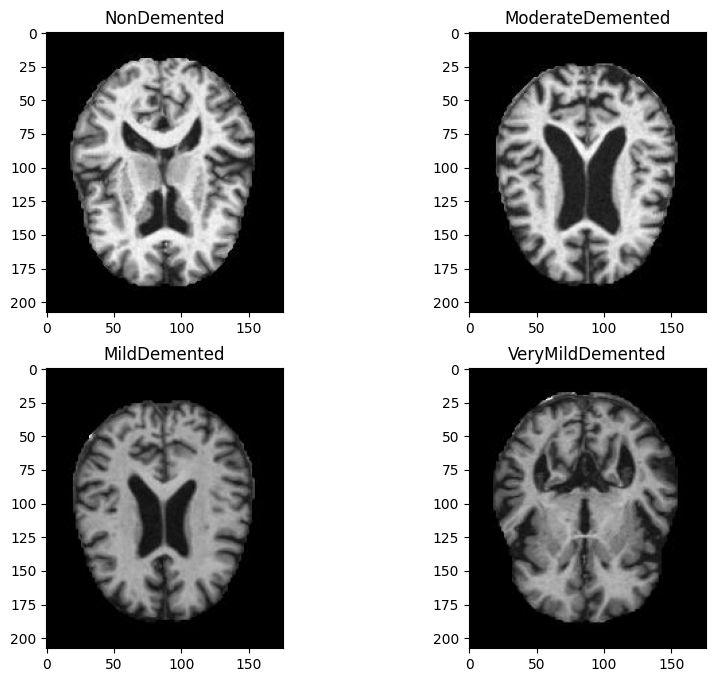

In [8]:
plt.figure(figsize=(10,8))
class_name = ['NonDemented', 'ModerateDemented',  'MildDemented', 'VeryMildDemented']

for i in range(4):
    plt.subplot(2,2,i+1)
    df = chemin_train[chemin_train['class'] == i]
    plt.imshow(df.iloc[0]['array_photo'], cmap='gray')
    plt.title(class_name[i])

plt.show()

Nous allons regarder l'équilibre entre les classes pour avoir une idée de la répartition :

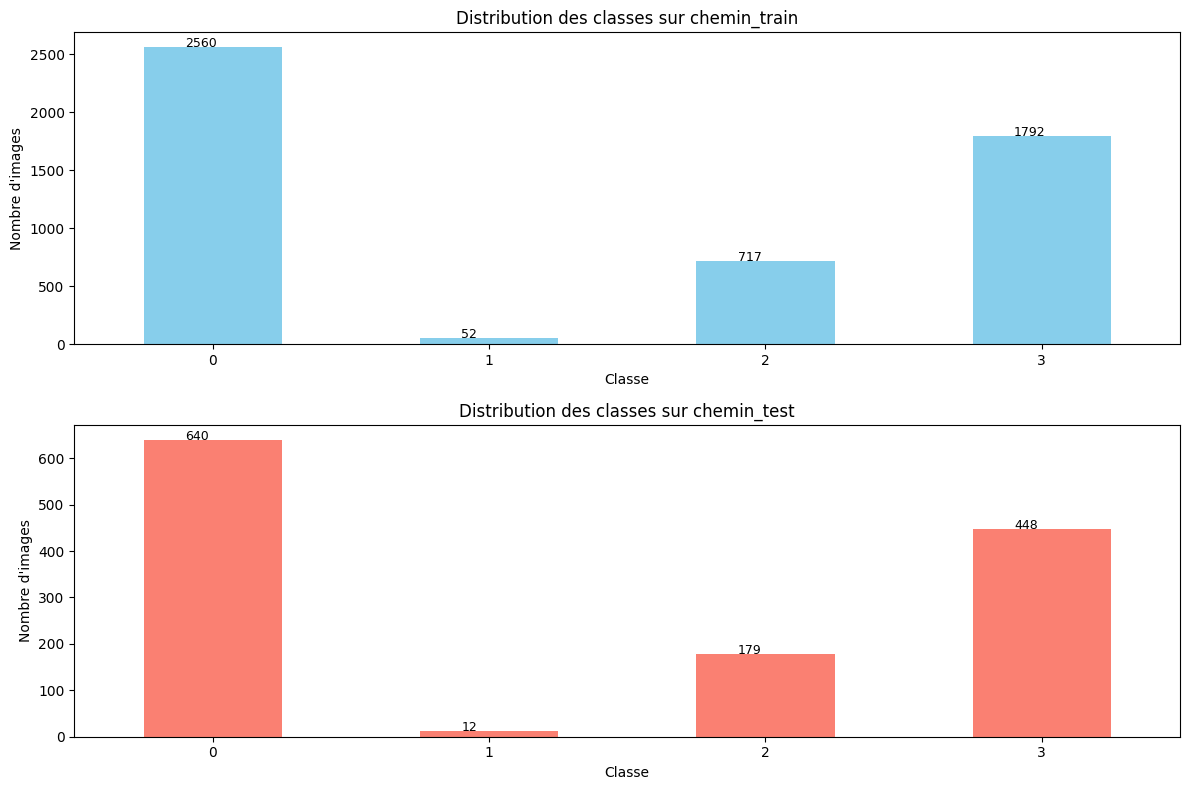

In [9]:
class_counts_train = chemin_train['class'].value_counts().sort_index()
class_counts_test = chemin_test['class'].value_counts().sort_index()

plt.figure(figsize=(12, 8))

# Plot pour chemin_train
plt.subplot(2, 1, 1)
bars_train = class_counts_train.plot(kind='bar', color='skyblue')
for bar in bars_train.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, str(int(bar.get_height())), fontsize=9)
plt.title('Distribution des classes sur chemin_train')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=0)

# Plot pour chemin_test
plt.subplot(2, 1, 2)
bars_test = class_counts_test.plot(kind='bar', color='salmon')
for bar in bars_test.patches:
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, str(int(bar.get_height())), fontsize=9)
plt.title('Distribution des classes sur chemin_test')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=0)

plt.tight_layout()  
plt.show()


On remarque un grand déséquilibre du nombre d'images par classe, ce qui signifie qu'il faudra utiliser une validation croisée spécifique pour garder une équiproportion des classes dans les plis, ce qui peut être le cas avec `StratifiedKFold`.

La classe la plus sous-représentée est `ModerateDemented`.

# 2. MODÈLES DE CLASSIFICATION <a class="anchor" id="chapter2"></a>
[Up](#up)

# 2.1. Support Vector Machine (SVM) <a class="anchor" id="section_2_1"></a>

In [10]:
# fonction pour extraire des caractéristiques des images
def extract_features(image_path, target_size=(100, 100)):
    image = cv2.imread(image_path) # Charger l'image en couleur

    image = cv2.resize(image, target_size) # Redimensionner l'image à la taille spécifiée

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convertir l'image en nuances de gris

    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0) # Appliquer une opération de lissage pour l'optimisation des performances

    edged_image = cv2.Canny(blurred_image, 50, 150) # Appliquer une détection de contours 

    features = edged_image.flatten() # Aplatir l'image en un vecteur d'une dimension

    return features

### 2.1.1 Création du modèle : <a class="anchor" id="section_2_1_1"></a>

In [11]:
# Ici, nous allons avoir X_test et X_train en fonction des features importants ressortis par la fonction "extract_features"
X_train_features = np.array([extract_features(path) for path in X_train])
X_test_features = np.array([extract_features(path) for path in X_test])

In [ ]:
svm_model = SVC() # Création d'un modèle par défaut pour avoir un aperçu de l'efficacité de la classification SVM
svm_model.fit(X_train_features, y_train)

SVC()

Première évaluation du modèle par `cross-validation` sur les données d'entrainement grâce à StratifiedKFold : 

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

n_splits = 5 
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

performances = cross_val_score(svm_model, X_train_features, y_train, cv=stratified_kfold, scoring='accuracy')

moyenne_performance = performances.mean()
print(f'Moyenne des performances : {moyenne_performance}')

Moyenne des performances : 0.9080257240853659


Nous obtenons le très bon score de 0.91 pour l'évaluation du modèle à partir des données d'entrainement.

Maintenant, calculons le score sur les données de test pour évaluer la performance de généralisation du modèle :

In [ ]:
y_pred = svm_model.predict(X_test_features)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.5293197810789679
Confusion Matrix:
[[460   0  11 169]
 [  8   0   0   4]
 [ 98   0  11  70]
 [231   0  11 206]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.72      0.64       640
           1       0.00      0.00      0.00        12
           2       0.33      0.06      0.10       179
           3       0.46      0.46      0.46       448

    accuracy                           0.53      1279
   macro avg       0.34      0.31      0.30      1279
weighted avg       0.50      0.53      0.50      1279



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

On observe un score de 0.53, ce qui montre que notre modèle généralise assez mal les nouvelles données et notamment la classe numéro 1 (ModerateDemented) qui correspond à la classe qui comporte le moins de données.

### 2.1.2. Recherche de meilleurs hyperparamètres : <a class="anchor" id="section_2_1_2"></a>

Utilisation de la cross-validation classique `KFold` car après plusieurs essais avec `StratifiedKFold`, le résultat est presque le même mais les temps d'exécutions beaucoup plus conséquents.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'degree': [2, 3, 4], 'kernel': ['rbf', 'poly']}

grid_search = GridSearchCV(svm_model, param_grid, cv=2, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_features, y_train)

print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure performance:", grid_search.best_score_)

Meilleurs paramètres: {'C': 10, 'degree': 2, 'kernel': 'poly'}
Meilleure performance: 0.837143312548809


In [ ]:
import tensorflow as tf

2023-12-09 21:28:46.258103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [10], 'degree': [2], 'kernel': ['rbf', 'poly'], 'gamma':[1e-2, 1, 10]}

grid_search = GridSearchCV(svm_model, param_grid, cv=2, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_features, y_train)

print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleure performance:", grid_search.best_score_)

Meilleurs paramètres: {'C': 10, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
Meilleure performance: 0.8939671240482234


In [ ]:
def extract_features_advanced(image_path, target_size=(100, 100)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    features = image.flatten()
    return features

X_train_features = np.array([extract_features_advanced(path) for path in X_train])
X_test_features = np.array([extract_features_advanced(path) for path in X_test])

svm_model = SVC(kernel='poly', C=10, degree=2, gamma=0.01)
svm_model.fit(X_train_features, y_train)

y_pred = svm_model.predict(X_test_features)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.6512900703674745
Confusion Matrix:
[[522   0   1 117]
 [  4   4   0   4]
 [ 70   0  47  62]
 [181   0   7 260]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.82      0.74       640
           1       1.00      0.33      0.50        12
           2       0.85      0.26      0.40       179
           3       0.59      0.58      0.58       448

    accuracy                           0.65      1279
   macro avg       0.78      0.50      0.56      1279
weighted avg       0.67      0.65      0.63      1279



On obtient une précision de 65% sur les données de test et on remarque que ce sont les classes 1 et 4 qui sont les moins bien différenciées par le modèle.

# 2.2. Random Forest <a class="anchor" id="section_2_2"></a>
[Up](#up)

In [8]:
from sklearn.ensemble import RandomForestClassifier

## 2.2.1 Random Forest classique <a class="anchor" id="section_2_2_1"></a>
[Up](#up)

In [9]:
# creation des listes X_train ....
nb_img = len(chemin_train)
liste_photo = np.zeros((nb_img,208,176))
for i in range(nb_img):
    liste_photo[i] = chemin_train['array_photo'][i]
    
y_train_RF = np.array(chemin_train['class'])
y_train_RF = y_train_RF.reshape(-1, 1)

X_train_RF = liste_photo.reshape(nb_img, -1)

X_train_RF.shape , y_train_RF.shape    

((5121, 36608), (5121, 1))

In [10]:
forest = RandomForestClassifier(n_estimators=750,
                                max_depth=1076, # seulement 1076 pixels sur 36068
                                random_state=1
                                )

In [11]:
forest.fit(X_train_RF, y_train_RF)
# prend 11sec avec 20 arbres et 1076 pixels : accuracy 0.55
# prend 2min avec 200 arbres et 1076 pixels : accuracy 0.64
# prend 7m avec 750 arbres et 1076 pixels

RandomForestClassifier(max_depth=1076, n_estimators=750, random_state=1)

In [12]:
imp = forest.feature_importances_
importances = imp.reshape(liste_photo[0].shape) # revenir à la forme d'image originale

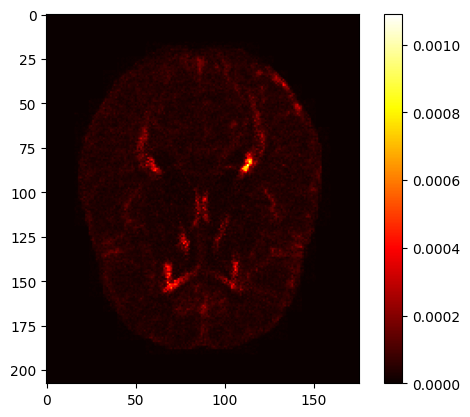

In [13]:
# affiche les points important du random forest
# on peut voir que tous les contours ne sont pas important
# on va donc les enlever par la suite pour gagner en temps de calcul 
# et peut-etre en précision
plt.imshow(importances, cmap='hot')
plt.colorbar()

Test du modèle classique :

In [14]:
nb_img = len(chemin_test)
liste_photo_test = np.zeros((nb_img,208,176))
for i in range(nb_img):
    liste_photo_test[i] = chemin_test['array_photo'][i]
    
X_test_RF = liste_photo_test.reshape(nb_img, -1)

y_test_RF = np.array(chemin_test['class'])
y_test_RF = y_test_RF.reshape(-1, 1)

X_test_RF.shape , y_test_RF.shape

((1279, 36608), (1279, 1))

In [15]:
# Faire des prédictions sur l'ensemble de test
y_pred_RF = forest.predict(X_test_RF)

# Évaluer la précision du modèle
accuracy = accuracy_score(y_test_RF, y_pred_RF)
print(f"Précision du modèle : {accuracy}")
# score de 0.65

Précision du modèle : 0.653635652853792


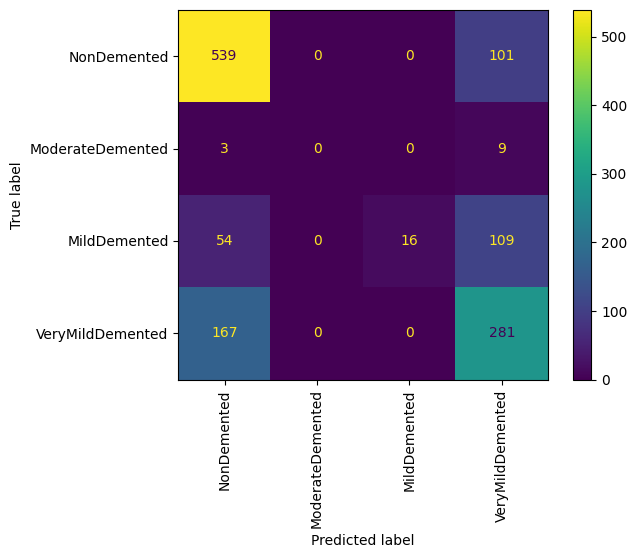

In [16]:
# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test_RF, y_pred_RF)

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

ConfusionMatrixDisplay.from_predictions(y_true=y_test_RF, y_pred=y_pred_RF, display_labels=['NonDemented', 'ModerateDemented', 'MildDemented', 'VeryMildDemented'], xticks_rotation='vertical')
plt.show()


- Pour la classe 0 : 543 bien prédits et 97 qui sont prédits dans la classe 3

- Pour la classe 1 : seulement 12 images et aucune n'est bonne, 6 dans classe 0 et 6 dans classe 3

- Pour la classe 3 : même chose seulement 17 sont bien trouvées et 45 sont dans la classe 0 et 117 dans classe 3 

- Pour la classe 4 : 277 bien prédits et 171 dans la classe 0 

## 2.2.2 Random Forest avec seulement les points importants <a class="anchor" id="section_2_2_2"></a>
[Up](#up)

In [17]:
# selection des pixels "importants" 
# (on a essayé d'enlever ici le contours des cerveaux, les pixels toujours noirs)
chemin_train['important_points'] = [image[importances !=0 ]  for image in chemin_train['array_photo']]
chemin_test['important_points'] = [image[importances !=0 ]  for image in chemin_test['array_photo']]

In [18]:
nb_img = len(chemin_train)
liste_photo = np.zeros((nb_img,chemin_train['important_points'][0].shape[0] ))
for i in range(nb_img):
    liste_photo[i] = chemin_train['important_points'][i]
    
X_train_RF_imp = liste_photo
X_train_RF_imp.shape

(5121, 21083)

In [19]:
forest = RandomForestClassifier(n_estimators=1000,
                                max_depth=619, # seulement 619 pixels sur 21072
                                random_state=1
                                )

In [20]:
forest.fit(X_train_RF_imp, y_train_RF)
# prend 11 min avec 1000 arbres et 619 pixels : accuracy 0.65
# prend 10.58 min avec 1000 arbres et 1000 pixels : accuracy 0.65
# prend 11.49 min avec 1000 arbres et 2000 pixels

RandomForestClassifier(max_depth=619, n_estimators=1000, random_state=1)

Test du modele avec sélection des points importants : 

In [21]:
nb_img = len(chemin_test)
liste_photo_test = np.zeros((nb_img,chemin_test['important_points'][0].shape[0] ))
for i in range(nb_img):
    liste_photo_test[i] = chemin_test['important_points'][i]
    
X_test_RF_imp = liste_photo_test
X_test_RF_imp.shape

(1279, 21083)

In [22]:
# Faire des prédictions sur l'ensemble de test
y_pred_RF_imp = forest.predict(X_test_RF_imp)

# Évaluer la précision du modèle
accuracy = accuracy_score(y_test_RF, y_pred_RF_imp)
print(f"Précision du modèle : {accuracy}")
# score de 0.67, petite amélioration

Précision du modèle : 0.6653635652853792


## 2.2.3 Random Forest classe 0 contre classe 3 avec les points "importants" <a class="anchor" id="section_2_2_3"></a>
[Up](#up)

In [23]:
RF_C0_C3 = chemin_test[(chemin_train['class'] == 0) | (chemin_train['class'] == 3) ].reset_index().copy()
nb_img = len(RF_C0_C3)
liste_photo_train = np.zeros((nb_img,chemin_train['important_points'][0].shape[0]))
for i in range(len(RF_C0_C3)):
    liste_photo_train[i] = RF_C0_C3['important_points'][i]
    
X_train_RF_C0_C3 = liste_photo_train.reshape(nb_img, -1)

y_train_RF_C0_C3 = np.array(RF_C0_C3['class'])
y_train_RF_C0_C3 = y_train_RF_C0_C3.reshape(-1, 1)

X_train_RF_C0_C3.shape, y_train_RF_C0_C3.shape

((1279, 21083), (1279, 1))

In [24]:
forest = RandomForestClassifier(n_estimators=750,
                                max_depth=1076, # 
                                random_state=1
                                )

In [25]:
forest.fit(X_train_RF_C0_C3, y_train_RF_C0_C3)

RandomForestClassifier(max_depth=1076, n_estimators=750, random_state=1)

In [26]:
RF_C0_C3 = chemin_test[(chemin_test['class'] == 0) | (chemin_test['class'] == 3) ].reset_index().copy()
nb_img = len(RF_C0_C3)
liste_photo_test = np.zeros((nb_img, chemin_train['important_points'][0].shape[0]))
for i in range(len(RF_C0_C3)):
    liste_photo_test[i] = RF_C0_C3['important_points'][i]
    
X_test_RF_C0_C3 = liste_photo_test.reshape(nb_img, -1)

y_test_RF_C0_C3 = np.array(RF_C0_C3['class'])
y_test_RF_C0_C3 = y_test_RF_C0_C3.reshape(-1, 1)

X_test_RF_C0_C3.shape, y_test_RF_C0_C3.shape


((1088, 21083), (1088, 1))

In [27]:
y_pred_RF_C0_C3 = forest.predict(X_test_RF_C0_C3)

# Évaluer la précision du modèle
accuracy = accuracy_score(y_test_RF_C0_C3, y_pred_RF_C0_C3)
print(f"Précision du modèle : {accuracy}")

Précision du modèle : 1.0


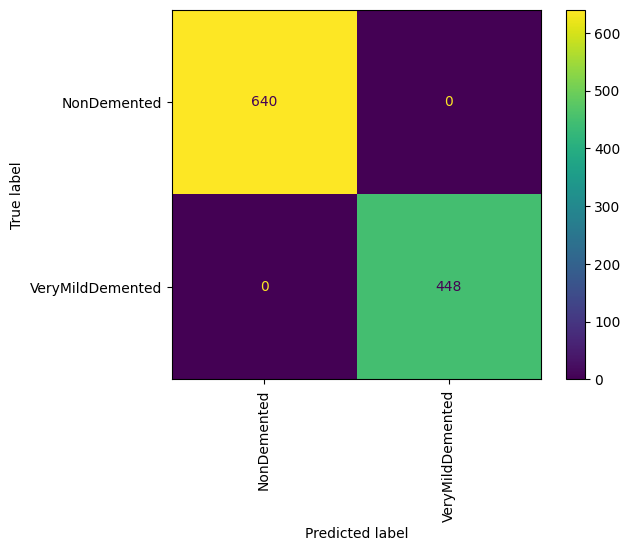

In [28]:
ConfusionMatrixDisplay.from_predictions(y_true=y_test_RF_C0_C3, y_pred=y_pred_RF_C0_C3, display_labels=['NonDemented', 'VeryMildDemented'], xticks_rotation='vertical')
plt.show()

In [29]:
imp_RF_C0_C3 = forest.feature_importances_

In [30]:
a=0
for i in range(imp_RF_C0_C3.shape[0]):
    if imp_RF_C0_C3[i] == 0:
        a += 1
print(a)

2415


In [33]:
imp_RF_C0_C3.shape

(21083,)

In [35]:
# on cherche maintenant le nombre de pixel a selectionner pour avoir 75 % de l'information
indices_tries = np.unravel_index(np.argsort(imp_RF_C0_C3, axis=None)[::-1], shape=imp_RF_C0_C3.shape)
conf = 0.75
imp = 0
nb_pixel = 0
for i in range(784):
    imp = np.sum(imp_RF_C0_C3[np.unravel_index(np.argsort(imp_RF_C0_C3, axis=None)[::-1][:i], shape=imp_RF_C0_C3.shape)])
    nb_pixel +=1
    if conf < imp :
        break
print(nb_pixel)

784


Dans cette partie, l'objectif était d'améliorer le modèle en opposant les deux classes extrêmes `NonDemented` et `VeryMildDemented` afin d'en retirer les features_importances et de voir s'il y a une réelle différence entre ces deux classes. 

On pourrait désormais afficher les importances portant les 3/4 de l'information (correspond aux 784 pixels). Cependant, nous n'avons pas pu poursuivre par manque de temps. 

# 2.3. Logistic Regression <a class="anchor" id="section_2_3"></a>
[Up](#up)

## 2.3.1. Définition du modèle <a class="anchor" id="section_2_3_1"></a>

In [24]:
# Je fais une copie des dataframes pour utiliser les mêmes notations que j'avais utilisé de mon côté

# Entrainement
file_list = chemin_train.copy()

#Reshape de l'array pour utiliser dans les modèles 
file_list['array_reshape'] = [np.array(file_list.iloc[i]['array_photo']).reshape((1, file_list.iloc[0]['array_photo'].shape[0] * file_list.iloc[0]['array_photo'].shape[1])) for i in range(len(file_list['array_photo']))]

# Test 
file_list_test = chemin_test.copy()

# Reshape de l'array pour utiliser dans les modèles 
file_list_test['array_reshape'] = [np.array(file_list_test.iloc[i]['array_photo']).reshape((1, file_list_test.iloc[0]['array_photo'].shape[0] * file_list_test.iloc[0]['array_photo'].shape[1])) for i in range(len(file_list_test['array_photo']))]


In [25]:
# On va utiliser l'objet "LogisticRegression" de scikit-learn 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [26]:
# Création de l'estimateur
clf = LogisticRegression()

In [27]:
# Données d'entraînement
nb_img = len(file_list)
X_train = np.zeros((nb_img,36608)) # features d'entrainement
for i in range(nb_img):
    X_train[i] = file_list['array_reshape'][i]

y_train = np.array(file_list['class']) # target d'entrainement

In [28]:
print(X_train.shape)
y_train = y_train.reshape((len(file_list['class']),1))
print(y_train.shape)

(5121, 36608)
(5121, 1)


In [29]:
# Données de test
nb_img = len(file_list_test)
X_test = np.zeros((nb_img,36608)) # features de test
for i in range(nb_img):
    X_test[i] = file_list_test['array_reshape'][i]

y_test = np.array(file_list_test['class']) # target de test

In [30]:
print(X_test.shape)
y_test = y_test.reshape((len(file_list_test['class']),1))
print(y_test.shape)

(1279, 36608)
(1279, 1)


## 2.3.2. Optimisation des hyper-paramètres <a class="anchor" id="section_2_3_2"></a>

Afin de trouver les meilleurs hyper-paramètres pour notre modèle, on va utiliser la méthode *GridSearchCV* du module `sklearn.model_selection`. Puisque cette méthode met plusieurs dizaines de minutes à s'executer, on va mettre le code en commentaire mais on note que les meilleurs paramètres sont :

- *C = 0.1*
- *penalty = 'l2'*

In [31]:
# GridSearchCV

# from sklearn.model_selection import GridSearchCV

# grid={"C":np.logspace(-3,3,7), "penalty":["none","l1","l2"]}              # liste des hyperparameters à optimiser

# clf_cv =GridSearchCV(clf,grid,cv=10)

In [32]:
# clf_cv.best_params_                          # les meilleurs hyper-paramètres

In [33]:
# clf_cv.fit(X_train, y_train)

In [34]:
clf_opti = LogisticRegression(penalty='l2', C = 0.1)

In [35]:
clf_opti.fit(X_train, y_train)

/home/pierre-etienne/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pierre-etienne/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.1)

In [36]:
y_predit = clf_opti.predict(X_test)

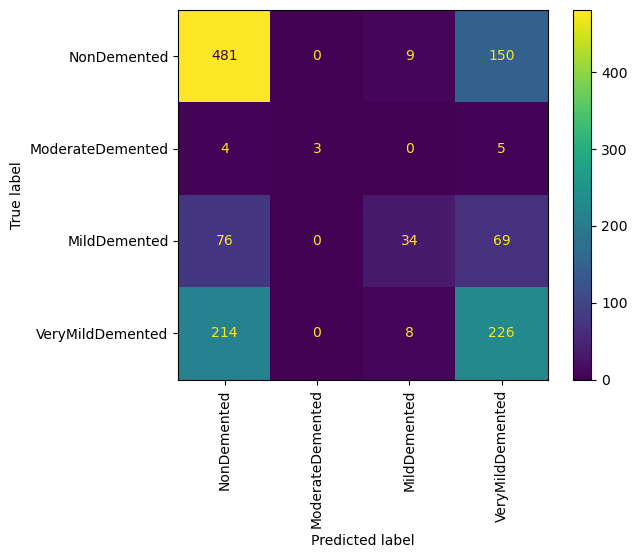

In [37]:
# Matrice de confusion
cm = confusion_matrix(y_pred = y_predit, y_true = y_test)

# Visualisation
ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_predit, display_labels=['NonDemented', 'ModerateDemented',  'MildDemented', 'VeryMildDemented'], xticks_rotation='vertical')
plt.show()

In [38]:
# Cross-validation score (plutôt long à executer, environ 5mn)
from sklearn.model_selection import ShuffleSplit , cross_val_score

SSS = ShuffleSplit(n_splits=10)
# On utilise un shuffle split pour être sur de bien piocher dans chaque catégories

cv_reg_log = cross_val_score(LogisticRegression(penalty='l2', C=0.1),
                             X_train,
                             y_train,
                             cv=SSS,
                             scoring='accuracy'
                             )

/home/pierre-etienne/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/pierre-etienne/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/pierre-etienne/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

In [41]:
lr_score = cv_reg_log.mean()
lr_score # Score de validation 

0.9424951267056529

In [42]:
clf_opti.score(X_test, y_test)

0.581704456606724

Nous pouvons voir que le modèle ne parvient pas à généraliser nos nouvelles données de test, ce n'est donc pas satifaisant.

# 3. Conclusion <a class="anchor" id="chapter3"></a>
[Up](#up)

Les différents modèles utilisés pour prédire la classe d'appartenance des images aux différents stades de développement de la maladie d'Alzheimer ne sont pas totalement satisfaisant. Les meilleurs modèles parmis ceux utilisés sont le Random Forest et le SVM avec une précision sur les données de test d'environ 65%. 

Ceci pourrait être amélioré par du feature engineering si nous avions la possibilité d'être orienté vers les parties du cerveau importants ou encore par l'utilisation de modèles plus adaptés tels que le Convolutional Neural Network (CNN).